In [106]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style('darkgrid')
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
# !pip install xgboost
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.inspection import permutation_importance


from scipy.stats import f_oneway
from statsmodels.stats.multicomp import pairwise_tukeyhsd
seed = 42

In [126]:
train= pd.read_csv('train.csv')
test= pd.read_csv('test.csv')

In [128]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1095 entries, 0 to 1094
Data columns (total 46 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   OverallQual    1095 non-null   float64
 1   Neighborhood   1095 non-null   float64
 2   GrLivArea      1095 non-null   float64
 3   GarageArea     1095 non-null   float64
 4   GarageCars     1095 non-null   float64
 5   YearBuilt      1095 non-null   float64
 6   TotalBsmtSF    1095 non-null   float64
 7   BsmtQual       1095 non-null   float64
 8   ExterQual      1095 non-null   float64
 9   KitchenQual    1095 non-null   float64
 10  1stFlrSF       1095 non-null   float64
 11  MSSubClass     1095 non-null   float64
 12  GarageYrBlt    1095 non-null   float64
 13  FullBath       1095 non-null   float64
 14  YearRemodAdd   1095 non-null   float64
 15  2ndFlrSF       1095 non-null   float64
 16  GarageFinish   1095 non-null   float64
 17  Foundation     1095 non-null   float64
 18  Exterior

In [146]:
X_train, y_train = train.drop(columns='SalePrice'), train['SalePrice']
X_test, y_test = test.drop(columns='SalePrice'), test['SalePrice']

In [148]:
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5, random_state=seed)

In [150]:
print('X_train shpae : ',X_train.shape,'\nX_test shpae : ',X_test.shape,'\nX_val shpae : ',X_val.shape)

X_train shpae :  (1095, 45) 
X_test shpae :  (182, 45) 
X_val shpae :  (183, 45)


## Decision Tree Regressor

In [153]:
param_dist = {
    'max_depth':np.arange(1,10),
    'min_samples_split': np.arange(2,50),
    'min_samples_leaf':np.arange(1,50),
    'max_features':['sqrt','log2',None],
    'criterion':['squared_error', 'friedman_mse', 'absolute_error', 'poisson'],
    'ccp_alpha':np.arange(0.0001,0.01,0.001),
    'min_impurity_decrease':np.arange(0.0001,0.01,0.001)
             }

random_search = RandomizedSearchCV(
    DecisionTreeRegressor(
        random_state=seed,
    ),
    param_dist,
    n_iter=250,
    verbose=4,
    n_jobs=-1,
    return_train_score=True,
    refit='r2',
    random_state=seed
)

In [155]:
random_search.fit(X_train,y_train)

Fitting 5 folds for each of 250 candidates, totalling 1250 fits


RandomizedSearchCV(estimator=DecisionTreeRegressor(random_state=42), n_iter=250,
                   n_jobs=-1,
                   param_distributions={'ccp_alpha': array([0.0001, 0.0011, 0.0021, 0.0031, 0.0041, 0.0051, 0.0061, 0.0071,
       0.0081, 0.0091]),
                                        'criterion': ['squared_error',
                                                      'friedman_mse',
                                                      'absolute_error',
                                                      'poisson'],
                                        'max_depth': array([1, 2, 3, 4, 5, 6, 7, 8, 9]),
                                        'max_features': ['sqrt', 'log2', None],
                                        'm...
                                        'min_samples_leaf': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49]),
                                        'min_samples_split': array([ 2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18,
       19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35,
       36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49])},
                   random_state=42, refit='r2', return_train_score=True,
                   verbose=4)

In [157]:
random_search.best_params_

{'min_samples_split': 15,
 'min_samples_leaf': 14,
 'min_impurity_decrease': 0.0081,
 'max_features': 'sqrt',
 'max_depth': 6,
 'criterion': 'friedman_mse',
 'ccp_alpha': 0.0001}

In [159]:
print('CV R2 Score: ',random_search.best_score_)

CV R2 Score:  0.7049602722744911


In [161]:
mse = mean_squared_error(y_train,random_search.predict(X_train))
r2 = r2_score(y_train,random_search.predict(X_train))
print('Train MSE: ',mse)
print('Trian R2 Score: ',r2)

Train MSE:  0.03380207163439882
Trian R2 Score:  0.7814817691403577


In [163]:
print('tree depth: ',random_search.best_estimator_.get_depth())

tree depth:  6


In [165]:
mse = mean_squared_error(y_test,random_search.predict(X_test))
test_r2 = r2_score(y_test,random_search.predict(X_test))
print('test MSE: ',mse)
print('Test R2 Score: ',test_r2)

test MSE:  0.04634899243753478
Test R2 Score:  0.7635544491773533


In [16]:
# A function to visualize Hyperparameter space

def plot_hpperform(
                searchcv,
                row=None,
                col=2,
                figsize=(15,15),
                line_kws={'errorbar':None},
                point_kws={},
                best_color=None,
                scatter_kws={'alpha':.4},
                strip_kws={'alpha':.4},
                fontsize=12,
                plot_train_score=False,
                train_color=None,
                points=True,
                best=True
                ):


    '''
    Plot hyperparameter peroformance in hyperparameter space
    '''
    # import seaborn
    try:
        import seaborn as sns
    except ImportError:
        import subprocess
        import sys
        print("Installing seaborn...")
        subprocess.check_call([sys.executable, "-m", "pip", "install", "seaborn"])
        import seaborn as sns

    # initializing necessary variables
    cv_results_ = searchcv.cv_results_
    keys = cv_results_.keys()
    param_ = [i for i in keys if 'param_' in i]
    row = len(param_) // col + 1 if not row else row
    n_splits_ = searchcv.n_splits_
    
    fig, axes = plt.subplots(row,col,figsize=figsize)
    axes = axes.flatten()

    # delete unncessary axes
    unused = (row*col) - len(param_)
    for i in range(unused):
        axes[-(i+1)].remove()

    # setting up x and y for plotting
    all_cv_score = []
    if plot_train_score:
        all_train_score = [] 
        train_color = sns.color_palette()[1] if not train_color else train_color
    for j in range(n_splits_):
        all_cv_score.extend(cv_results_[f'split{j}_test_score'])
        if plot_train_score:
            all_train_score.extend(cv_results_[f'split{j}_train_score'])

    # looping over to plot all the hyperparameters vs score        
    for i in range(len(param_)):
        ax = axes[i]   
        
        kws = dict(
            y= all_cv_score,
            x= np.tile(cv_results_[param_[i]],5),
            ax=ax,
        )

        # avoiding error for None
        kws['x'] = ['None' if i is None else i for i in kws['x'] ]
        
        
        if plot_train_score:
            train_kws = dict(
                y= all_train_score,
                x= np.tile(cv_results_[param_[i]],5),
                ax=ax,
                color=train_color
            )
            train_kws['x'] = ['None' if i is None else i for i in train_kws['x']]

        # plotting pointplot and stripplot for categorical values
        if isinstance(kws['x'][0],str):
            sns.pointplot(**kws,**point_kws,label='CV Scores')
            if points:
                sns.stripplot(**kws,**strip_kws)
            
            # plotting train scores
            if plot_train_score:
                sns.pointplot(**train_kws,**point_kws,label='train_score')
                if points:
                  sns.stripplot(**train_kws,**strip_kws)

            # plotting the best parameter
            if best:
                best_score_ = searchcv.best_score_
                best_x = [searchcv.best_params_[param_[i].replace('param_','')]]
                best_x = ['None' if best_x[0] is None else best_x[0]]
                best_color = sns.color_palette()[3] if not best_color else best_color
                sns.pointplot(y=best_score_,x=best_x,color=best_color,ax=ax,label='best Hyperparameter')
        
        # plotting lineplot and scatterplot for nuumerical values
        else:
            sns.lineplot(**kws,**line_kws,label='CV Scores')
            if points:
                sns.scatterplot(**kws,**scatter_kws)

            # plotting train scores
            if plot_train_score:
                sns.lineplot(**train_kws,**line_kws,label='train_score')
                if points:
                    sns.scatterplot(**train_kws,**scatter_kws)
            
            # plotting the best parameter
            if best:
                best_score_ = searchcv.best_score_
                best_x = [searchcv.best_params_[param_[i].replace('param_','')]]
                best_color = sns.color_palette()[3] if not best_color else best_color
                sns.scatterplot(y=best_score_,x=best_x,color=best_color,ax=ax,label='best Hyperparameter')
        
        ax.set_xlabel(param_[i].replace('param_',''),fontsize=fontsize)
        ax.set_ylabel('score',fontsize=fontsize)
        ax.legend()
   
    plt.suptitle('Hyperparameter Performance',y=0.95,fontsize=fontsize*2)
    return fig,axes.reshape(row,col)

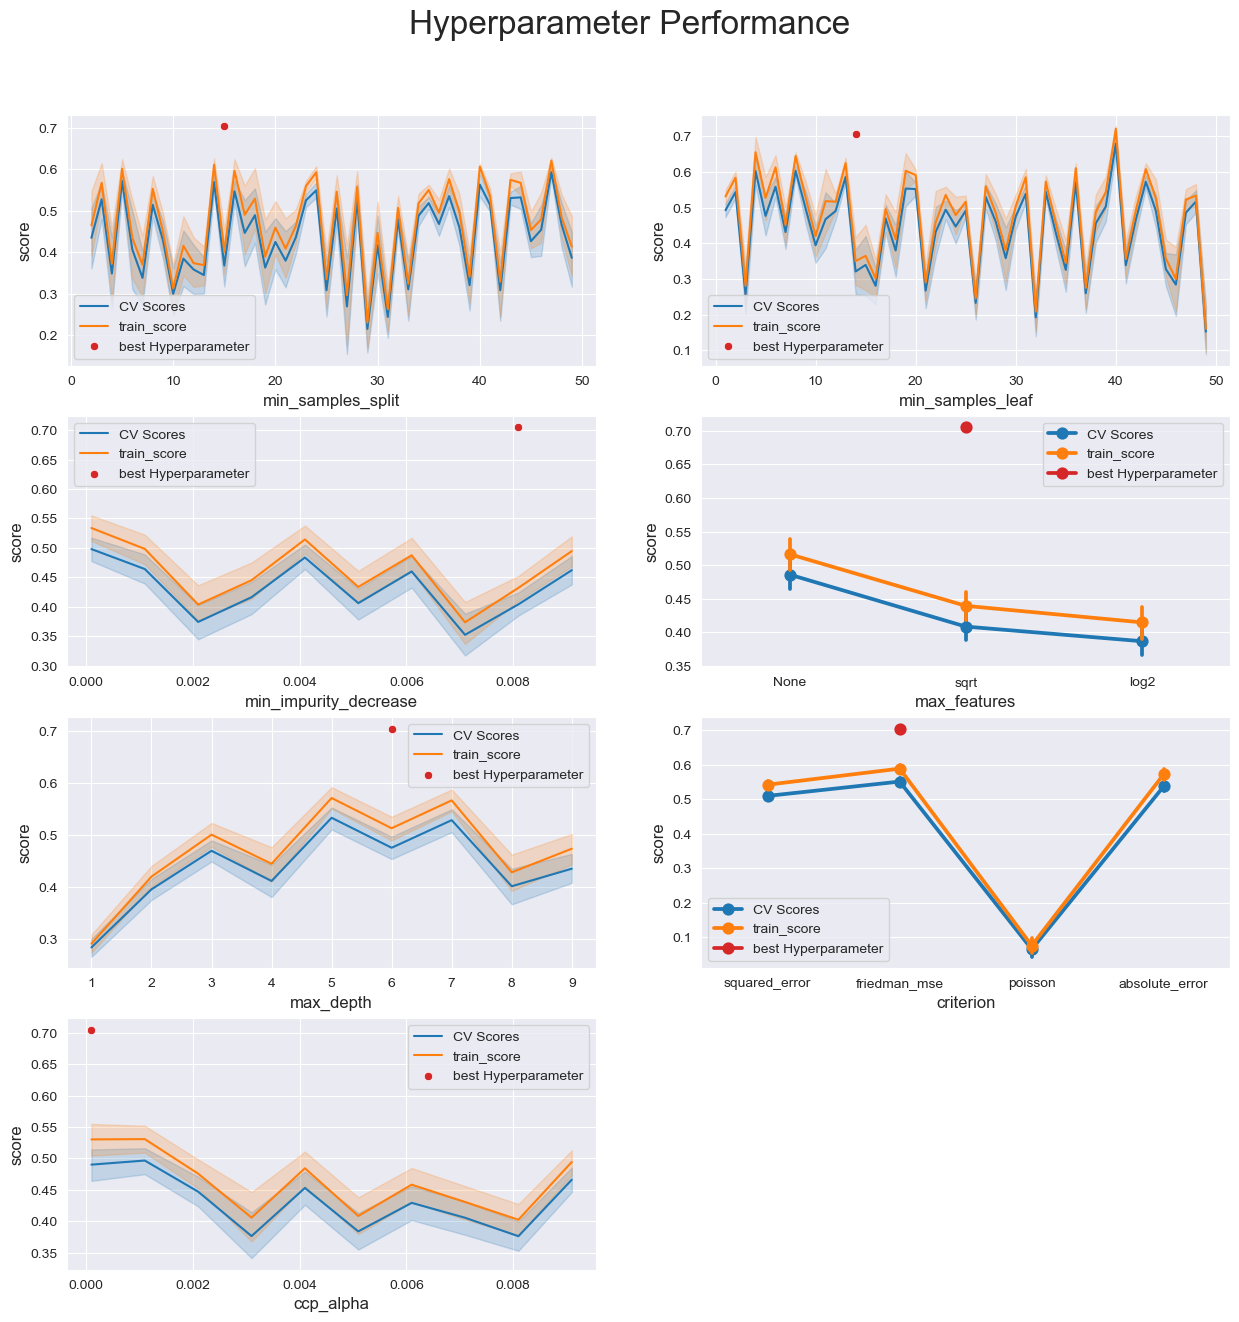

In [167]:
plot_hpperform(random_search,line_kws=dict(errorbar=('ci',80)),plot_train_score=True,points=False,best=True)
plt.show()

In [169]:
dt = DecisionTreeRegressor(
  min_samples_split= 15,
  min_samples_leaf= 14,
  max_features= None,
  max_depth= 6,
  criterion= 'friedman_mse',
  ccp_alpha= 0.0001,
  random_state=seed
    )

In [171]:
dt.fit(X_train,y_train)

DecisionTreeRegressor(ccp_alpha=0.0001, criterion='friedman_mse', max_depth=6,
                      min_samples_leaf=14, min_samples_split=15,
                      random_state=42)

In [173]:
mse = mean_squared_error(y_train,dt.predict(X_train))
train_r2 = r2_score(y_train,dt.predict(X_train))
print('Train MSE: ',mse)
print('Trian R2 Score: ',train_r2)

Train MSE:  0.022463173191453436
Trian R2 Score:  0.8547836677473082


In [175]:
mse = mean_squared_error(y_test,dt.predict(X_test))
test_r2 = r2_score(y_test,dt.predict(X_test))
print('test MSE: ',mse)
print('Test R2 Score: ',test_r2)

test MSE:  0.04081189106522446
Test R2 Score:  0.7918015137861731


In [177]:
print('Trian R2 Score: ',train_r2)
print('Test R2 Score: ',test_r2)

Trian R2 Score:  0.8547836677473082
Test R2 Score:  0.7918015137861731


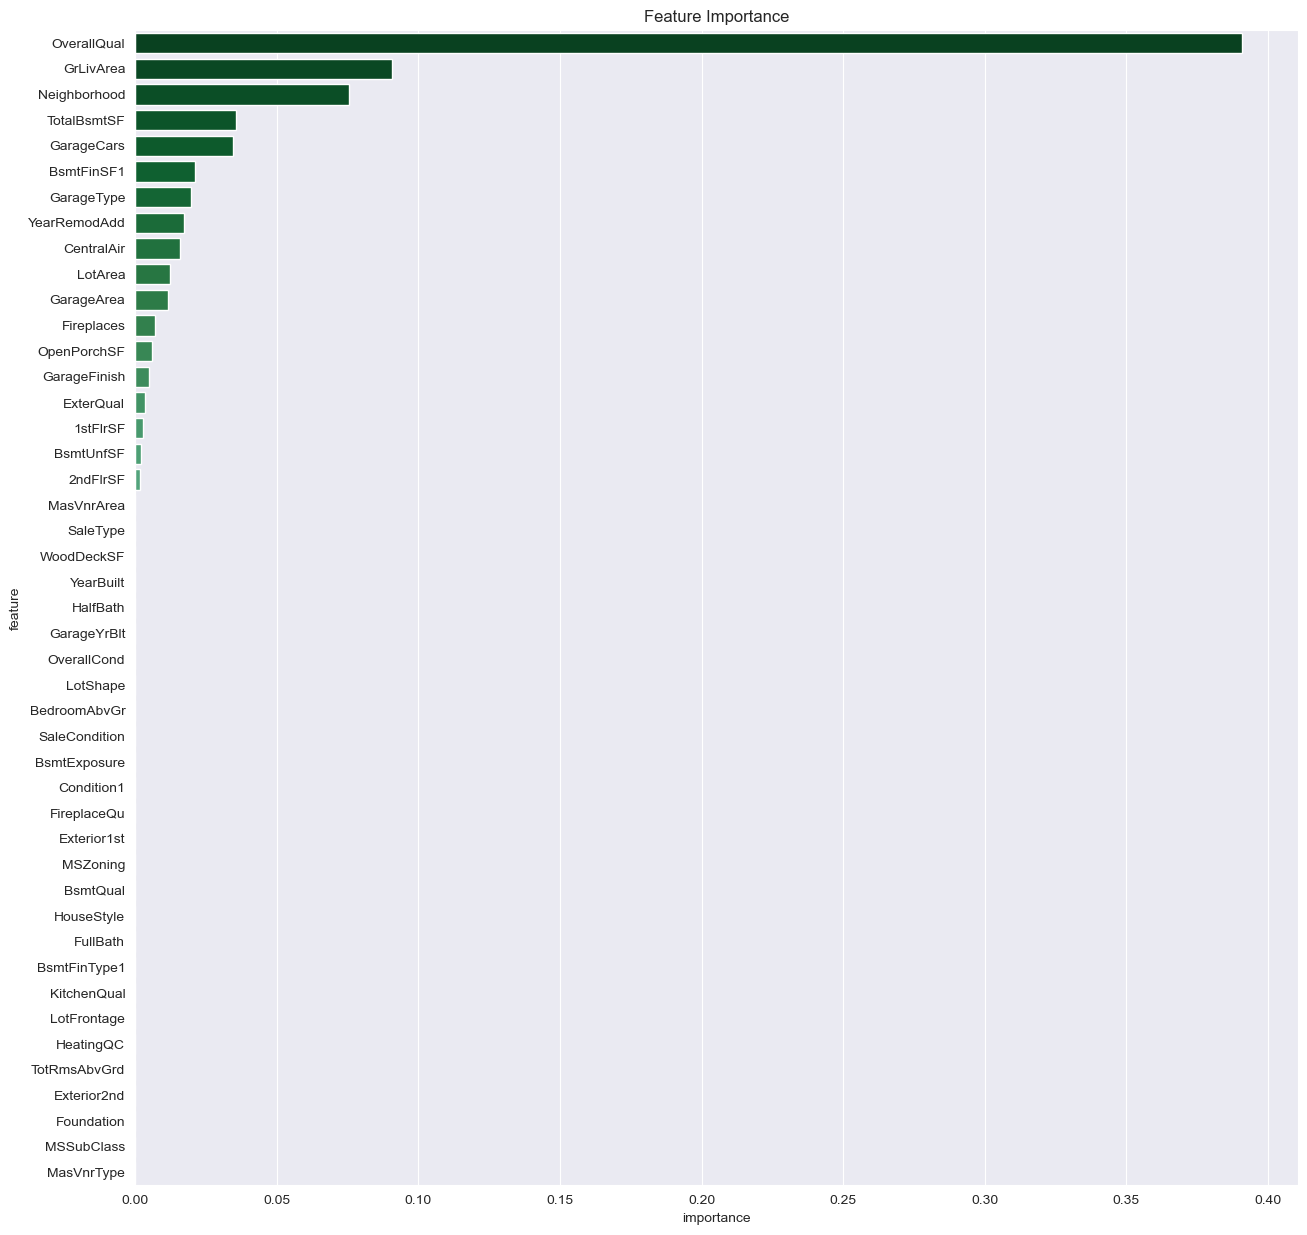

In [243]:
result = permutation_importance(dt,X_test,y_test,n_repeats=10,random_state=seed)
feat_imp = pd.DataFrame({'feature':X_test.columns,'importance':result.importances_mean}).sort_values(by='importance',ascending=False)

plt.figure(figsize=(15,15))
sns.barplot(data=feat_imp,x='importance',y='feature',hue='feature',palette='BuGn_r')
plt.title('Feature Importance')
plt.show()

## Random Forest Regressor

In [179]:
param_dist = {
    'n_estimators':np.arange(50,110,10),
    'max_depth':np.arange(1,13),
    'min_samples_split': np.arange(2,50),
    'min_samples_leaf':np.arange(1,50),
    'max_features':['sqrt','log2',None],
    'criterion':['squared_error', 'friedman_mse', 'absolute_error', 'poisson'],
    'ccp_alpha':np.arange(0.0001,0.01,0.001),
    'min_impurity_decrease':np.arange(0.0001,0.01,0.001)
             }

random_search = RandomizedSearchCV(
    RandomForestRegressor(
        random_state=seed
    ),
    param_dist,
    n_iter=250,
    verbose=4,
    n_jobs=-1,
    return_train_score=True,
    refit='r2',
    random_state=seed
)

In [181]:
random_search.fit(X_train,y_train)

Fitting 5 folds for each of 250 candidates, totalling 1250 fits


RandomizedSearchCV(estimator=RandomForestRegressor(random_state=42), n_iter=250,
                   n_jobs=-1,
                   param_distributions={'ccp_alpha': array([0.0001, 0.0011, 0.0021, 0.0031, 0.0041, 0.0051, 0.0061, 0.0071,
       0.0081, 0.0091]),
                                        'criterion': ['squared_error',
                                                      'friedman_mse',
                                                      'absolute_error',
                                                      'poisson'],
                                        'max_depth': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12]),
                                        'max_features': ['sqrt', 'log2'...
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49]),
                                        'min_samples_split': array([ 2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18,
       19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35,
       36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49]),
                                        'n_estimators': array([ 50,  60,  70,  80,  90, 100])},
                   random_state=42, refit='r2', return_train_score=True,
                   verbose=4)

In [182]:
random_search.best_params_

{'n_estimators': 60,
 'min_samples_split': 12,
 'min_samples_leaf': 20,
 'min_impurity_decrease': 0.0001,
 'max_features': None,
 'max_depth': 11,
 'criterion': 'squared_error',
 'ccp_alpha': 0.0001}

In [185]:
print('CV R2 Score: ',random_search.best_score_)

CV R2 Score:  0.8163383773871665


In [187]:
mse = mean_squared_error(y_train,random_search.predict(X_train))
r2 = r2_score(y_train,random_search.predict(X_train))
print('Train MSE: ',mse)
print('Trian R2 Score: ',r2)

Train MSE:  0.01987979078446406
Trian R2 Score:  0.8714843054867644


In [189]:
mse = mean_squared_error(y_test,random_search.predict(X_test))
test_r2 = r2_score(y_test,random_search.predict(X_test))
print('test MSE: ',mse)
print('Test R2 Score: ',test_r2)

test MSE:  0.029011011999435826
Test R2 Score:  0.8520027221438804


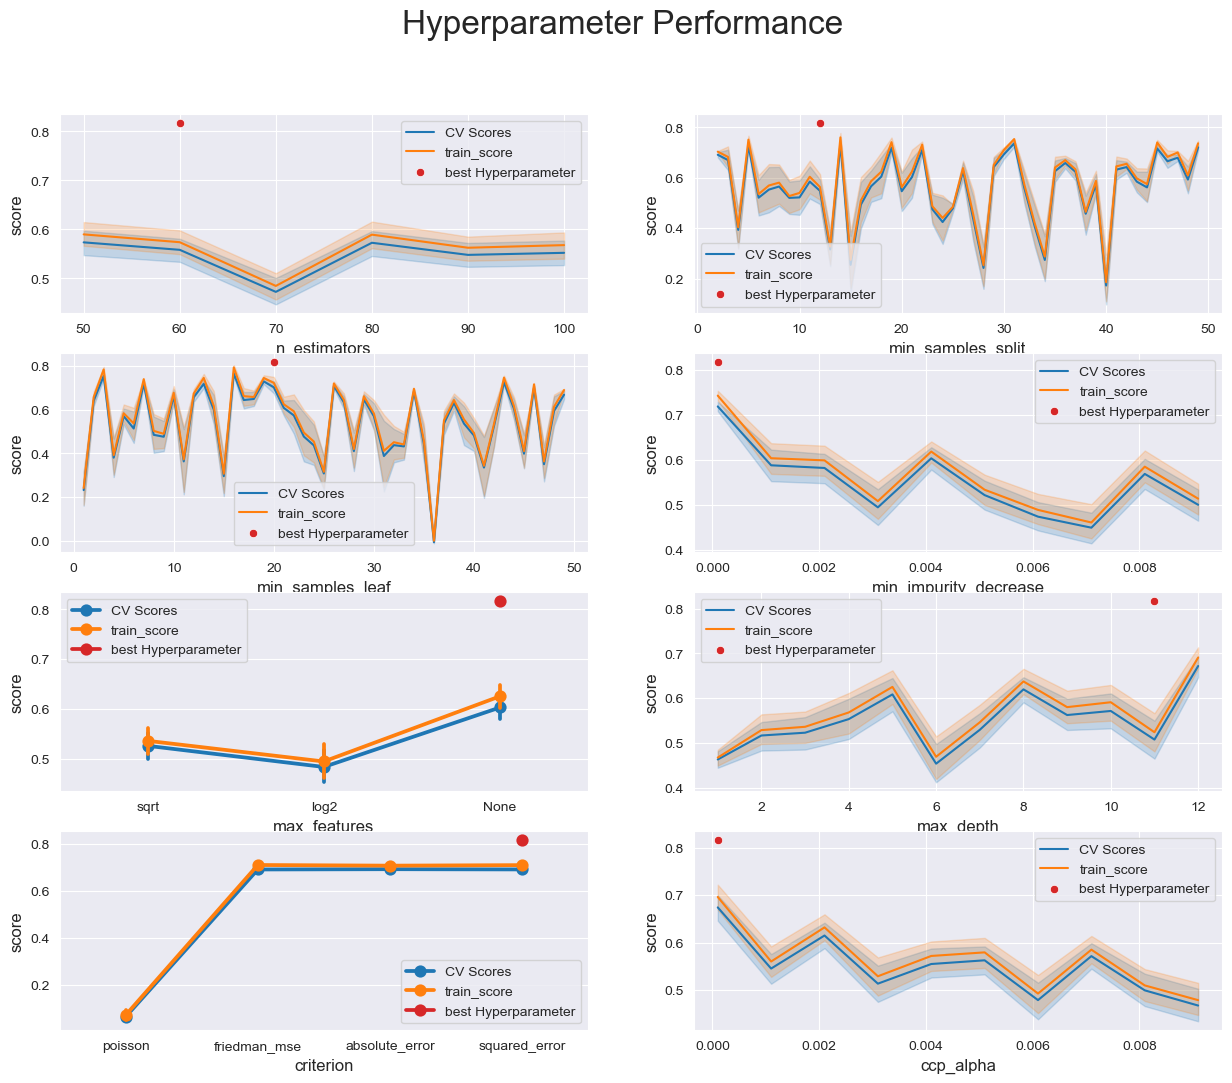

In [191]:
plot_hpperform(random_search,line_kws=dict(errorbar=('ci',80)),plot_train_score=True,points=False,best=True)
plt.show()

In [ ]:
{'n_estimators': 60,
 'min_samples_split': 12,
 'min_samples_leaf': 20,
 'min_impurity_decrease': 0.0001,
 'max_features': None,
 'max_depth': 11,
 'criterion': 'squared_error',
 'ccp_alpha': 0.0001}

In [197]:
rf = RandomForestRegressor(
    n_estimators=60,
    min_samples_split=12,
    min_samples_leaf=20,
    max_depth=11,
    random_state=seed,
    criterion= 'squared_error',
    ccp_alpha=0.0003
    )

In [199]:
rf.fit(X_train,y_train)

RandomForestRegressor(ccp_alpha=0.0003, max_depth=11, min_samples_leaf=20,
                      min_samples_split=12, n_estimators=60, random_state=42)

In [201]:
mse = mean_squared_error(y_train,rf.predict(X_train))
train_r2 = r2_score(y_train,rf.predict(X_train))
print('Train MSE: ',mse)
print('Trian R2 Score: ',train_r2)

Train MSE:  0.020439595392318485
Trian R2 Score:  0.8678653701191776


In [203]:
mse = mean_squared_error(y_test,rf.predict(X_test))
test_r2 = r2_score(y_test,rf.predict(X_test))
print('test MSE: ',mse)
print('Test R2 Score: ',test_r2)

test MSE:  0.029556120686008613
Test R2 Score:  0.8492218952719993


In [205]:
print('Trian R2 Score: ',train_r2)
print('Test R2 Score: ',test_r2)

Trian R2 Score:  0.8678653701191776
Test R2 Score:  0.8492218952719993


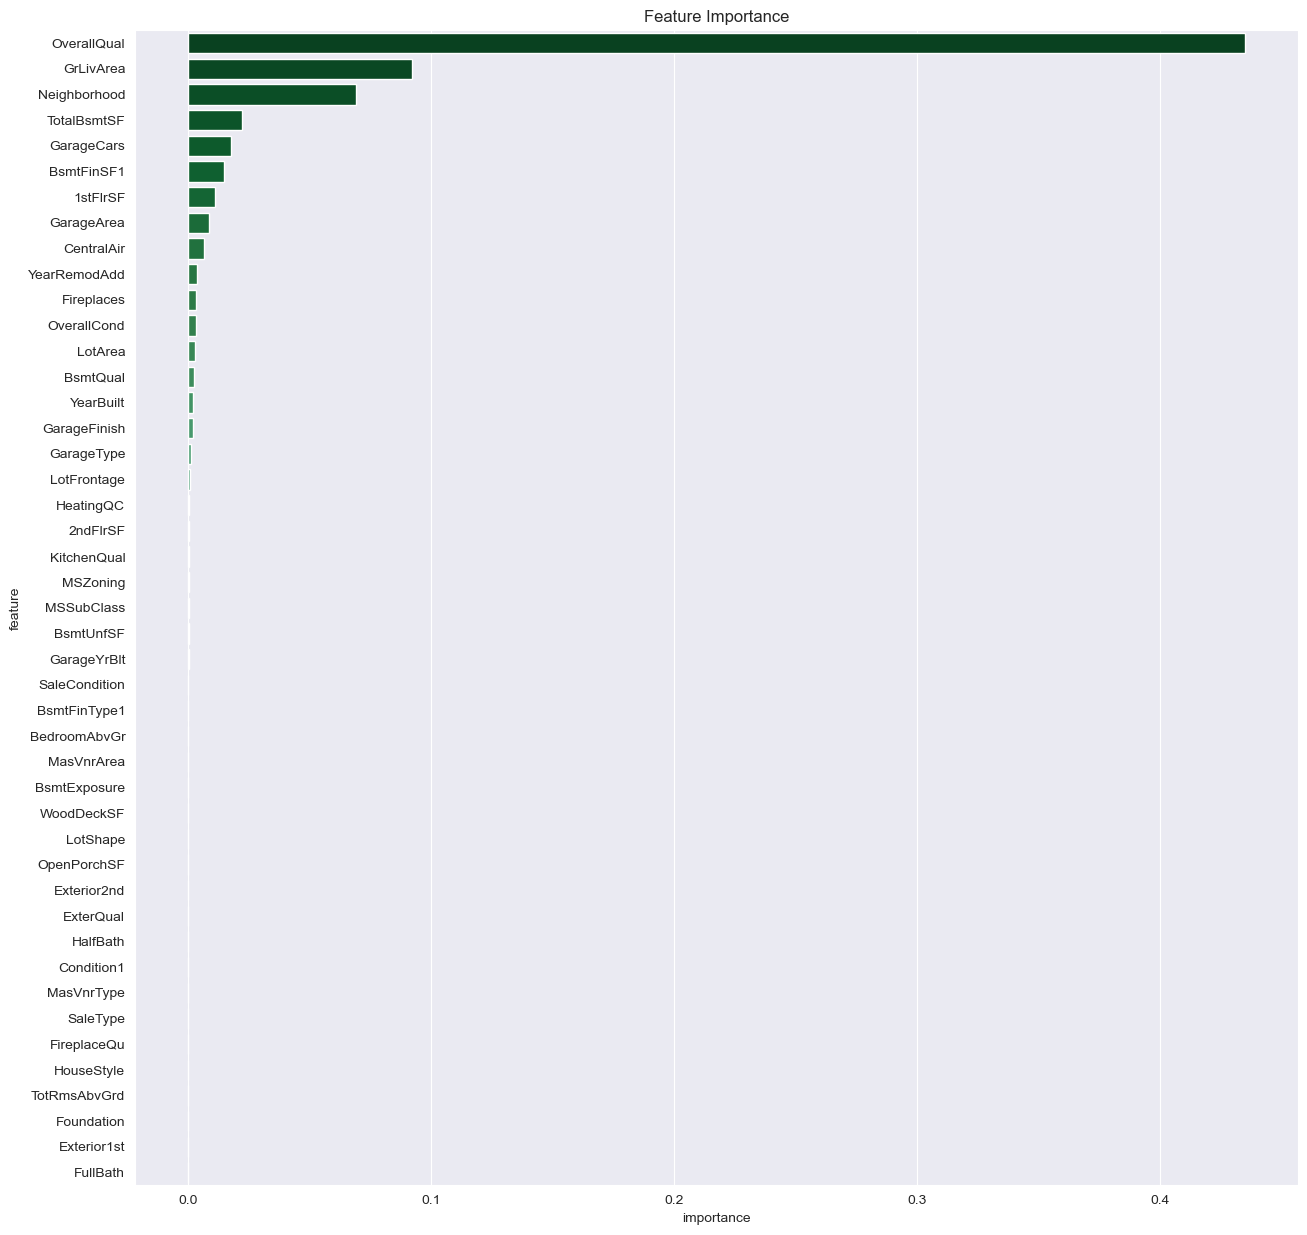

In [239]:
result = permutation_importance(rf,X_test,y_test,n_repeats=10,random_state=seed)
feat_imp = pd.DataFrame({'feature':X_test.columns,'importance':result.importances_mean}).sort_values(by='importance',ascending=False)

plt.figure(figsize=(15,15))
sns.barplot(data=feat_imp,x='importance',y='feature',hue='feature',palette='BuGn_r')
plt.title('Feature Importance')
plt.show()

## XGboost Regressor

In [208]:
param_dist = {
    'n_estimators':np.arange(10,70,10),
    'learning_rate':np.arange(0.05,0.2,0.01),
    'max_depth':np.arange(1,13),
    'max_leaves':np.arange(1,50),
    'colsample_bytree':np.arange(0.5,1,0.1),
    'min_child_weight':np.arange(1,11),
    'gamma':np.arange(0.5,1,0.1),
    'reg_lambda':np.arange(15,26)
             }

random_search = RandomizedSearchCV(
    XGBRegressor(
        random_state=seed,
        reg_alpha=5
    ),
    param_dist,
    n_iter=250,
    verbose=4,
    n_jobs=-1,
    return_train_score=True,
    refit='r2',
    random_state=seed
)

In [210]:
random_search.fit(X_train,y_train)

Fitting 5 folds for each of 250 candidates, totalling 1250 fits


RandomizedSearchCV(estimator=XGBRegressor(base_score=None, booster=None,
                                          callbacks=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None, device=None,
                                          early_stopping_rounds=None,
                                          enable_categorical=False,
                                          eval_metric=None, feature_types=None,
                                          feature_weights=None, gamma=None,
                                          grow_policy=None,
                                          importance_type=None,
                                          interaction_constraints=Non...
                                        'max_leaves': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49]),
                                        'min_child_weight': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10]),
                                        'n_estimators': array([10, 20, 30, 40, 50, 60]),
                                        'reg_lambda': array([15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25])},
                   random_state=42, refit='r2', return_train_score=True,
                   verbose=4)

In [212]:
random_search.best_params_

{'reg_lambda': 22,
 'n_estimators': 40,
 'min_child_weight': 5,
 'max_leaves': 4,
 'max_depth': 8,
 'learning_rate': 0.16000000000000003,
 'gamma': 0.5,
 'colsample_bytree': 0.7999999999999999}

In [214]:
print('CV R2 Score: ',random_search.best_score_)

CV R2 Score:  0.8056916920007803


In [216]:
mse = mean_squared_error(y_train,random_search.predict(X_train))
train_r2 = r2_score(y_train,random_search.predict(X_train))
print('Train MSE: ',mse)
print('Trian R2 Score: ',train_r2)

Train MSE:  0.024074681354078368
Trian R2 Score:  0.8443658473095126


In [218]:
mse = mean_squared_error(y_test,random_search.predict(X_test))
test_r2 = r2_score(y_test,random_search.predict(X_test))
print('test MSE: ',mse)
print('Test R2 Score: ',test_r2)

test MSE:  0.033324070906583785
Test R2 Score:  0.8300000089154208


In [220]:
print('Trian R2 Score: ',train_r2)
print('CV R2 Score: ',random_search.best_score_)
print('Test R2 Score: ',test_r2)

Trian R2 Score:  0.8443658473095126
CV R2 Score:  0.8056916920007803
Test R2 Score:  0.8300000089154208


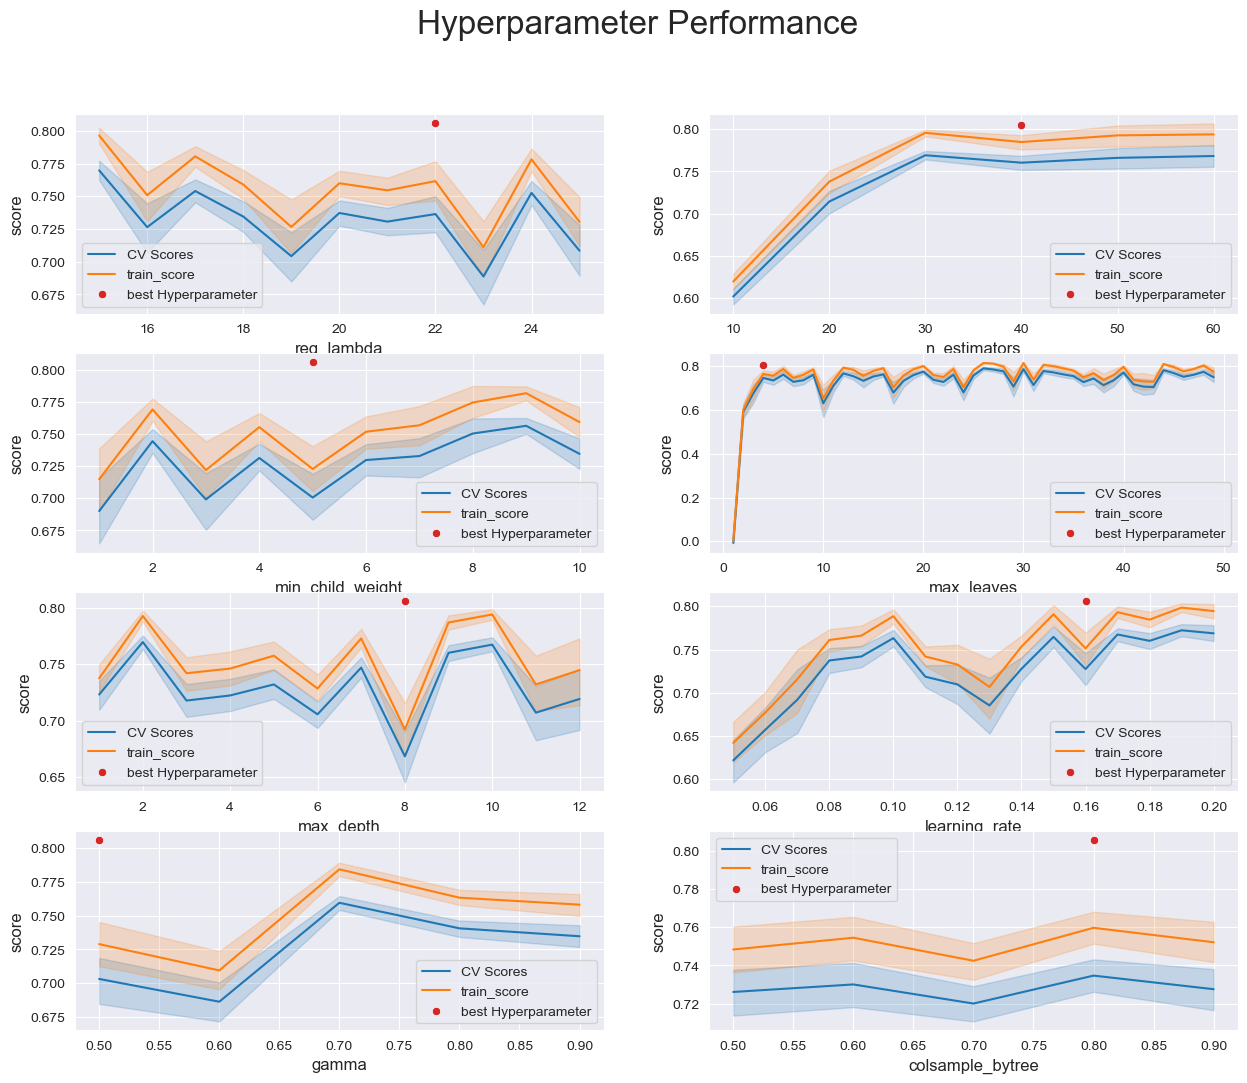

In [222]:
plot_hpperform(random_search,line_kws=dict(errorbar=('ci',80)),plot_train_score=True,points=False,best=True)
plt.show()

In [ ]:
{'reg_lambda': 24,
 'n_estimators': 40,
 'min_child_weight': 5,
 'max_leaves': 4,
 'max_depth': 8,
 'learning_rate': 0.16000000000000003,
 'gamma': 0.5,
 'colsample_bytree': 0.7999999999999999}

In [224]:
xgbr = XGBRegressor(
        reg_lambda=22,
        reg_alpha=5,
        random_state=seed,
        n_estimators=30,
        min_child_weight=9,
        max_leaves=4,
        max_depth=10,
        learning_rate=0.19,
        gamma=0.7,
        colsample_bytree=0.8
    )

In [226]:
xgbr.fit(X_train,y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=0.7, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.19, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=10,
             max_leaves=4, min_child_weight=9, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=30,
             n_jobs=None, num_parallel_tree=None, ...)

In [228]:
mse = mean_squared_error(y_train,xgbr.predict(X_train))
train_r2 = r2_score(y_train,xgbr.predict(X_train))
print('Train MSE: ',mse)
print('Trian R2 Score: ',train_r2)

Train MSE:  0.025955222749440635
Trian R2 Score:  0.832208823822387


In [230]:
mse = mean_squared_error(y_test,xgbr.predict(X_test))
test_r2 = r2_score(y_test,xgbr.predict(X_test))
print('test MSE: ',mse)
print('Test R2 Score: ',test_r2)

test MSE:  0.03434404341127904
Test R2 Score:  0.8247967035572374


In [232]:
print('Trian R2 Score: ',train_r2)
print('Test R2 Score: ',test_r2)

Trian R2 Score:  0.832208823822387
Test R2 Score:  0.8247967035572374


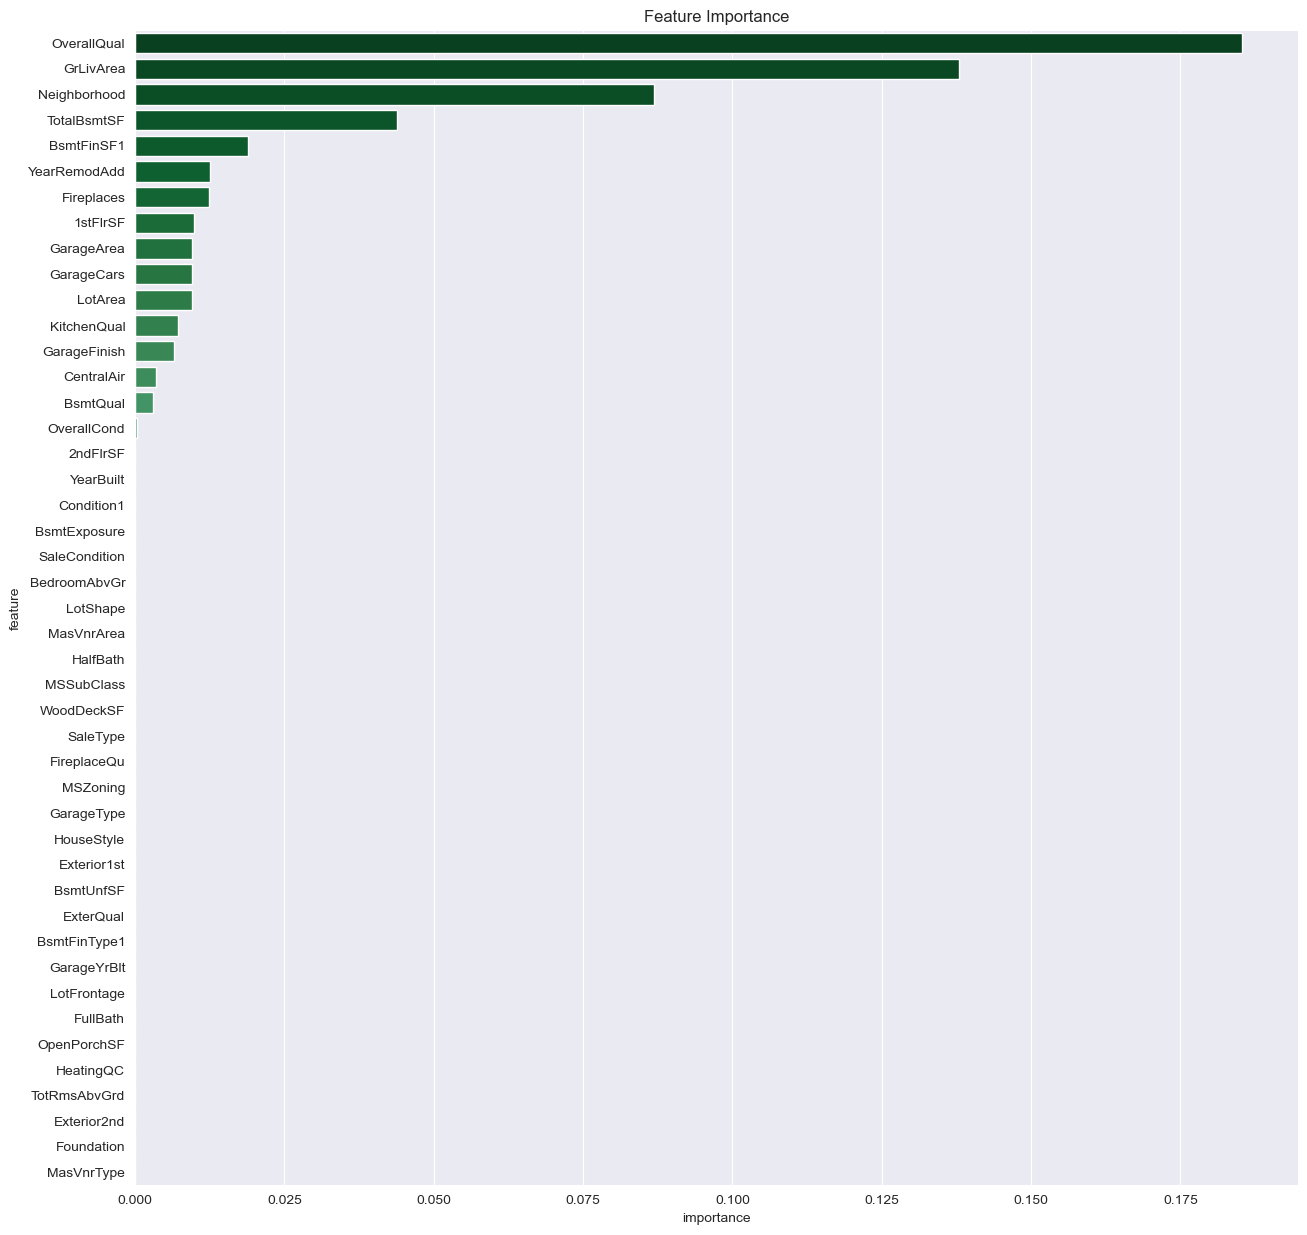

In [241]:
result = permutation_importance(xgbr,X_test,y_test,n_repeats=10,random_state=seed)
feat_imp = pd.DataFrame({'feature':X_test.columns,'importance':result.importances_mean}).sort_values(by='importance',ascending=False)

plt.figure(figsize=(15,15))
sns.barplot(data=feat_imp,x='importance',y='feature',hue='feature',palette='BuGn_r')
plt.title('Feature Importance')
plt.show()

### Model Significance Test

In [234]:
models = {'Decision Tree':dt,
          'Random Forest':rf,
          'XG Boost':xgbr}
cv_scores = {}
for name,model in models.items():
    scores = cross_val_score(model, X_val, y_val, cv=5, scoring="r2")
    cv_scores[name] = -scores

f_stat, pval = f_oneway(cv_scores['Decision Tree'],cv_scores['Random Forest'],cv_scores['XG Boost'])
print('ANOVA f-statistics ',f_stat,' p-value ',pval)

ANOVA f-statistics  5.9214250323014905  p-value  0.0162531846699242


p-value is less than 0.05 so there is significant difference exists.

In [237]:
scores = np.concatenate([cv_scores['Decision Tree'],cv_scores['Random Forest'],cv_scores['XG Boost']])
models = ['Decision Tree']*5 + ['Random Forest']*5 +['XG Boost']*5
tukey = pairwise_tukeyhsd(scores, models, alpha=0.05)
print(tukey.summary())

       Multiple Comparison of Means - Tukey HSD, FWER=0.05       
    group1        group2    meandiff p-adj   lower  upper  reject
-----------------------------------------------------------------
Decision Tree Random Forest  -0.0505 0.6715 -0.2061 0.1052  False
Decision Tree      XG Boost   0.1431 0.0728 -0.0126 0.2987  False
Random Forest      XG Boost   0.1935 0.0157  0.0379 0.3492   True
-----------------------------------------------------------------


We can come to this conclusion that Random Forest perofrms significantly better than Decision Tree and XGBoost.